In [2]:
! pip install matplotlib
! pip install pandas
! pip install seaborn

In [3]:
!pip install mysql-connector-python

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mysql.connector
import os

csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'), # Added payments.csv for specific handling
    ('order_items.csv', 'order_items')

]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='127.0.0.1',
    user='root',
    password='rootroot17@~',
    port = 3306,
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\nikit\OneDrive\Desktop\E-commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)

    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host='127.0.0.1',
    user='root',
    password='rootroot17@~',
    port = 3306,
    database='ecommerce'
)
cur = db.cursor()
    

## BASIC QUERIES

In [33]:
#1. List all unique cities where customers are located.
query = ''' select distinct(customer_city) from customers; '''

cur.execute(query)

data = cur.fetchall()
data
df = pd.DataFrame(data)
df.head(5)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [16]:
#2. Count the number of orders placed in 2017.
query = ''' select count(order_id) from orders where year(order_purchase_timestamp) = 2017; '''
cur.execute(query)

data = cur.fetchall()
data[0][0]  #if we call 0 index of data w'll get tuple 

180404

In [80]:
#3. Find the total sales per category.
query = ''' SELECT products.product_category category , round(sum(payments.payment_value),2) 
            FROM products 
            JOIN order_items
            ON products.product_id = order_items.product_id
            JOIN payments 
            ON payments.order_id = order_items.order_id
            group by category '''
cur.execute(query)

data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ['Category','Sales'])
df

,Category,Sales
0,perfumery,24323455.67
1,Furniture Decoration,68648466.81
2,telephony,23370338.43
3,bed table bath,82202576.21
4,automotive,40910127.89
...,...,...
69,cds music dvds,57572.64
70,La Cuisine,139849.44
71,Fashion Children's Clothing,37712.16
72,PC Gamer,104372.64


In [30]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


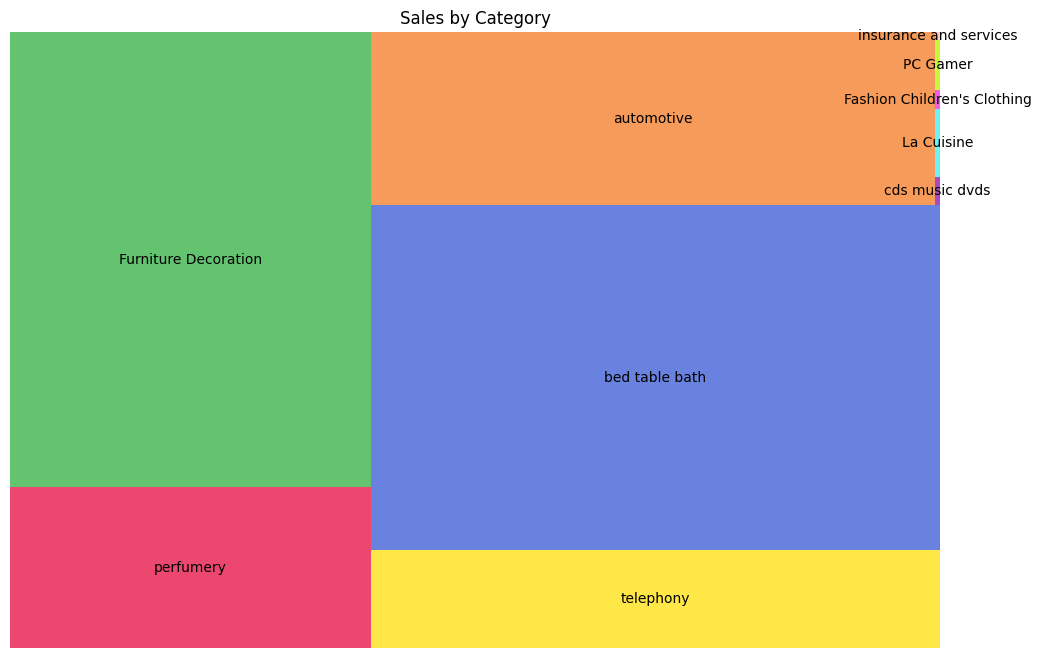

In [52]:
#TREEMAP
import matplotlib.pyplot as plt
import pandas as pd
import squarify
import numpy as np

# Create a custom colormap
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe']

# Create the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=df['Sales'], label=df['Category'],color=colors, alpha=0.8)

# Add title and show the plot
plt.title('Sales by Category')
plt.axis('off')
plt.show()


In [81]:
#4. Calculate the percentage of orders that were paid in installments.
query = ''' SELECT (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100
            FROM payments; '''  #case m sum payment_installments ka sum krha h.. if >=1 then 1 is added to sum else 0 would be added to the sum, total addition is divided by overall total no of installments(rows)  *100 = %of total orders paid in installments  
cur.execute(query)

data = cur.fetchall()
data[0][0]

Decimal('99.9981')

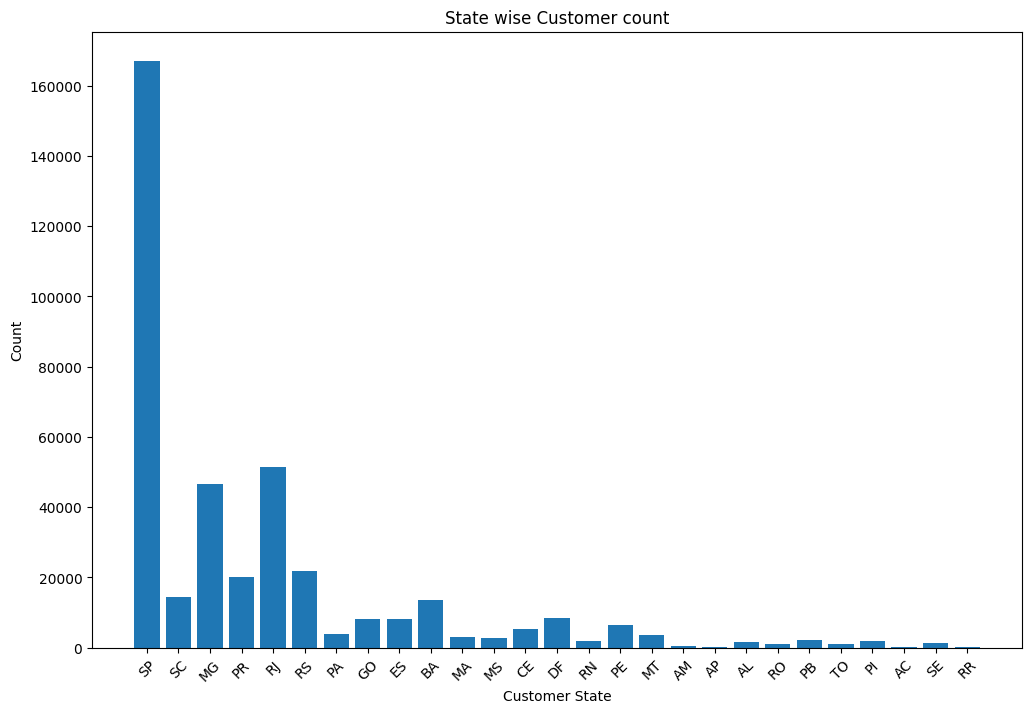

In [114]:
#5. Count the number of customers from each state.
query = '''select customer_state,count(customer_id)
           from customers
           group by customer_state;'''

cur.execute(query)

data = cur.fetchall()
data
df = pd.DataFrame(data,columns=['Customer State','Count'])
df
plt.figure(figsize=(12,8))
plt.bar( df['Customer State'], df['Count'])
plt.title('State wise Customer count')
plt.xlabel('Customer State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## INTERMEDIATE QUERIES

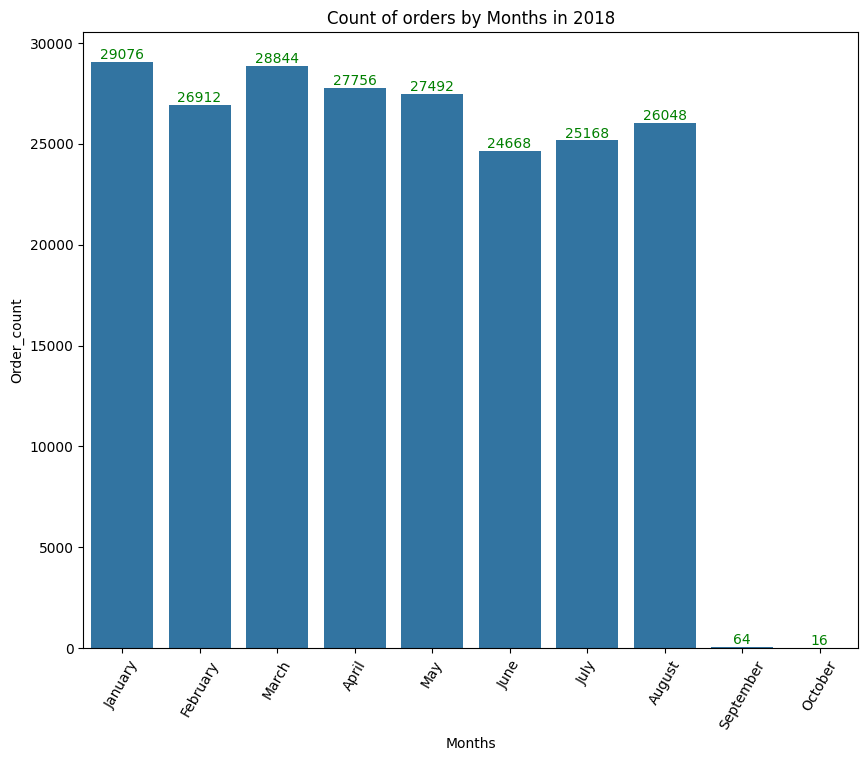

In [118]:
#1. Calculate the number of orders per month in 2018.
query = '''select monthname(order_purchase_timestamp) months, count(order_id) order_count
           from orders
           where year(order_purchase_timestamp)= 2018 
           group by months;'''

cur.execute(query)

data = cur.fetchall()
data
df = pd.DataFrame(data,columns=['Months','Order_count'])
df
o=['January','February','March','April','May','June','July','August','September','October']
plt.figure(figsize = (10,8))
ax= sns.barplot(x=df['Months'], y=df['Order_count'], data =df, order =o)
plt.xticks(rotation=60)
ax.bar_label(ax.containers[0],color= 'green')
plt.title('Count of orders by Months in 2018')
plt.show()

In [6]:
#2. Find the average number of products per order, grouped by customer city.
query = '''with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc  
from orders 
join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc;'''
#step1- order_id nd customer_id k basis p count of products(order_id) nikale hr order m hr customer k kitne products h
#step2- then city k basis p avg nikala
cur.execute(query)

data = cur.fetchall()
data
df = pd.DataFrame(data,columns= ['Customer_city','Average products per order'])
df.head(5)

,Customer_city,Average products per order
0,padre carvalho,84.00
1,celso ramos,78.00
2,datas,72.00
3,candido godoi,72.00
4,matias olimpio,60.00


In [10]:
#3. Calculate the percentage of total revenue contributed by each product category.
query = '''SELECT upper(products.product_category) Category , 
round((sum(payments.payment_value)/ (select sum(payment_value) from payments))*100 ,2) Sales_percentage
FROM products 
JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments 
ON payments.order_id = order_items.order_id
group by Category
order by Sales_percentage desc;'''

cur.execute(query)

data = cur.fetchall()
data
#df = pd.DataFrame(data,columns= ['Customer_city','Average products per order'])
#df.head(5)

[('BED TABLE BATH', 128.37),
 ('HEALTH BEAUTY', 124.23),
 ('COMPUTER ACCESSORIES', 118.83),
 ('FURNITURE DECORATION', 107.2),
 ('WATCHES PRESENT', 107.13),
 ('SPORT LEISURE', 104.35),
 ('HOUSEWARES', 82.06),
 ('AUTOMOTIVE', 63.89),
 ('GARDEN TOOLS', 62.84),
 ('COOL STUFF', 58.44),
 ('FURNITURE OFFICE', 48.49),
 ('TOYS', 46.4),
 ('BABIES', 40.47),
 ('PERFUMERY', 37.98),
 ('TELEPHONY', 36.5),
 ('STATIONARY STORE', 23.79),
 ('PET SHOP', 23.33),
 ('PCS', 20.92),
 ('ELECTRONICS', 19.48),
 (None, 18.95),
 ('CONSTRUCTION TOOLS CONSTRUCTION', 18.1),
 ('MUSICAL INSTRUMENTS', 17.47),
 ('ELECTROSTILE', 16.91),
 ('FASHION BAGS AND ACCESSORIES', 16.35),
 ('FIXED TELEPHONY', 15.52),
 ('GAMES CONSOLES', 14.65),
 ('BAGS ACCESSORIES', 14.03),
 ('CASA CONSTRUCAO', 10.24),
 ('ROOM FURNITURE', 10.2),
 ('ELECTRICES 2', 9.34),
 ('AGRO INDUSTRIA E COMERCIO', 8.9),
 ('HOME APPLIANCES', 7.16),
 ('CLIMATIZATION', 6.83),
 ('HOUSE COMFORT', 6.32),
 ('FURNITURE KITCHEN SERVICE AREA DINNER AND GARDEN', 5.6),
 ('CON

In [19]:
#4. Identify the correlation between product price and the number of times a product has been purchased.
query = '''SELECT products.product_category, count(order_items.product_id), round(avg(order_items.price),2)
FROM products 
JOIN order_items
ON products.product_id = order_items.product_id
GROUP BY products.product_category; '''

cur.execute(query)

data = cur.fetchall()
data
df = pd.DataFrame(data,columns= ['Category','Order_count','Price'])
df.head(5)
#Now we have to find CORRELATION(means if the 2 variables are impacting on each other, whether they are proportional or inverselry proportional to each other)
#EG: It exits btw (-1,1) where -1 means inversly proportional to each other and vice versa(if deaths increase if tobacco consumption is increasing) in a no of population.
#EG: Aslo like if a company's has high prices and its sales are dec then inversly proportional
arr1 = df['Order_count']
arr2 = df['Price']

a = np.corrcoef([arr1,arr2])  
# its coming out to be (-0.106 nearly 0)neutral means there  is no codependency 
print('The correlation btw price and no of times a product has been purchased is',a[0][-1])

The correlation btw price and no of times a product has been purchased is -0.10631514167157569


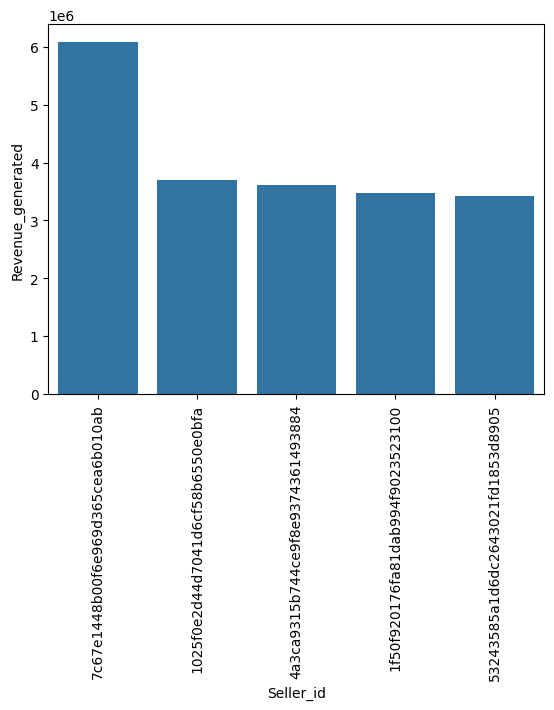

In [30]:
#5. Calculate the total revenue generated by each seller, and rank them by revenue.
query = '''SELECT*, dense_rank() over(order by revenue desc) as rn FROM
(SELECT order_items.seller_id , round(sum(payments.payment_value),2)
revenue FROM order_items
JOIN payments
ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id) as a ; '''

cur.execute(query)

data = cur.fetchall()
data
df = pd.DataFrame(data,columns= ['Seller_id','Revenue_generated','Rank'])
df =df.head()
sns.barplot(x='Seller_id',y='Revenue_generated', data=df)
plt.xticks(rotation=90)
plt.show()

# Advanced Queries


In [32]:
#1. Calculate the moving average of order values for each customer over their order history.
query = '''SELECT customer_id, order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg 
from
(SELECT orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
FROM payments
JOIN orders
ON payments.order_id = orders.order_id) as a ; '''

cur.execute(query)

data = cur.fetchall()
data
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
1662171,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662172,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662173,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662174,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
